# Understanding SVD

## Looking for dimensionality reduction

In [1]:
import numpy as np
A = np.array([[1, 3, 4], [2, 3, 5], [1, 2, 3], [5, 4, 6]])
print(A)

[[1 3 4]
 [2 3 5]
 [1 2 3]
 [5 4 6]]


In [2]:
U, s, Vh = np.linalg.svd(A, full_matrices=False)
print(np.shape(U), np.shape(s), np.shape(Vh))
print(s)

(4, 3) (3,) (3, 3)
[12.26362747  2.11085464  0.38436189]


In [3]:
print(np.dot(np.dot(U, np.diag(s)), Vh)) # Full matrix reconstruction

[[1. 3. 4.]
 [2. 3. 5.]
 [1. 2. 3.]
 [5. 4. 6.]]


In [4]:
print(np.round(np.dot(np.dot(U[:,:2], np.diag(s[:2])),
                      Vh[:2,:]),1)) # k=2 reconstruction

[[1.  2.8 4.1]
 [2.  3.2 4.8]
 [1.  2.  3. ]
 [5.  3.9 6. ]]


In [5]:
print(np.round(np.dot(np.dot(U[:,:1], np.diag(s[:1])), 
                      Vh[:1,:]),1)) # k=1 reconstruction

[[2.1 2.5 3.7]
 [2.6 3.1 4.6]
 [1.6 1.8 2.8]
 [3.7 4.3 6.5]]


# Performing Factor Analysis and PCA

## Looking for hidden factors

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_palmer_penguins():
    url = "https://raw.githubusercontent.com/allisonhorst/" \
          "palmerpenguins/main/inst/extdata/penguins.csv"
    numeric_features = ["bill_length_mm", "bill_depth_mm", 
                        "flipper_length_mm", "body_mass_g"]
    data = pd.read_csv(url).dropna()
    target = data.species.replace({'Adelie':1, 'Gentoo':2, 
                                   'Chinstrap':3})
    data[numeric_features] = StandardScaler() \
        .fit_transform(data[numeric_features])
    return data[numeric_features], target

X, y = load_palmer_penguins()

In [7]:
from sklearn.decomposition import FactorAnalysis
factor = FactorAnalysis(n_components=4).fit(X)

In [8]:
print(pd.DataFrame(factor.components_, columns=X.columns).T)

                          0         1    2    3
bill_length_mm     0.665834  0.179744 -0.0  0.0
bill_depth_mm     -0.561658  0.236985  0.0 -0.0
flipper_length_mm  0.874881 -0.009841  0.0 -0.0
body_mass_g        0.840450  0.010157  0.0  0.0


## Achieving dimensionality reduction

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components="mle").fit(X)
print('Explained variance by each component:',
      pca.explained_variance_ratio_.round(5),"\n")
print(pd.DataFrame(pca.components_, columns=X.columns).T)

Explained variance by each component: [0.68634 0.19453 0.09216] 

                          0         1         2
bill_length_mm     0.453753  0.600195  0.642495
bill_depth_mm     -0.399047  0.796170 -0.425800
flipper_length_mm  0.576825  0.005788 -0.236095
body_mass_g        0.549675  0.076464 -0.591737


## Squeezing information with t-SNE

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
            learning_rate="auto",
            init="random", 
            random_state=0,
            perplexity=50, 
            early_exaggeration=25,
            n_iter=300)

Tx = tsne.fit_transform(X)

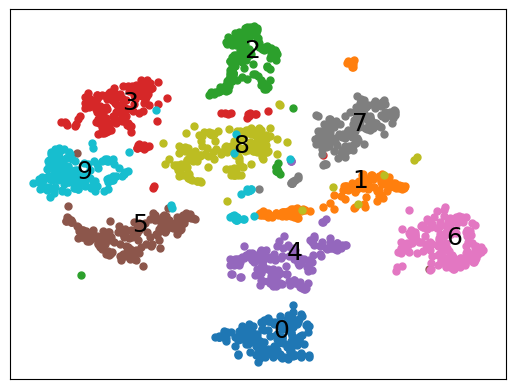

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xticks([], [])
plt.yticks([], [])
for target in np.unique(y):
    selection = y==target
    X1, X2 = Tx[selection, 0], Tx[selection, 1]
    c1, c2 = np.median(X1), np.median(X2)
    plt.plot(X1, X2, 'o', ms=5)
    plt.text(c1, c2, target, fontsize=18)

# Understanding Some Applications

## Recognizing faces with PCA

In [13]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True, 
                               random_state=101)
train_faces = dataset.data[:350,:]
test_faces  = dataset.data[350:,:]
train_answers = dataset.target[:350]
test_answers = dataset.target[350:]

In [14]:
print(dataset.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [15]:
from sklearn.decomposition import PCA
n_components = 25
Rpca = PCA(svd_solver='randomized', 
           n_components=n_components, 
           whiten=True)
Rpca.fit(train_faces)
print(f"Explained variance by {n_components}")
print(f"components: ",
      f"{np.sum(Rpca.explained_variance_ratio_):0.3f}")
compressed_train_faces = Rpca.transform(train_faces)
compressed_test_faces  = Rpca.transform(test_faces)

Explained variance by 25
components:  0.794


The represented person is subject 34


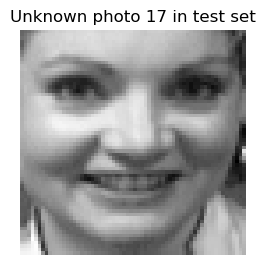

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

photo = 17
print(f"The represented person is subject "
      f"{test_answers[photo]}")
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(f"Unknown photo {photo} in test set")
plt.imshow(test_faces[photo].reshape(64, 64), 
           cmap=plt.cm.gray, interpolation="nearest")
plt.show()

In [17]:
mask = compressed_test_faces[photo,] 
squared_errors = np.sum((compressed_train_faces 
                         - mask)**2, axis=1)
minimum_error_face = np.argmin(squared_errors)
most_resembling = list(np.where(squared_errors < 20)[0])
print(f"Best resembling subject in training set: "
      f"{train_answers[minimum_error_face]}")

Best resembling subject in training set: 34


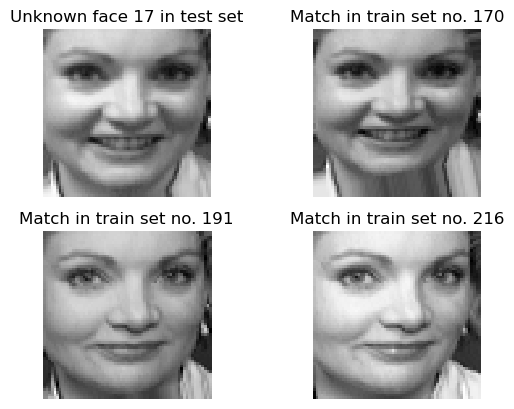

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title(f'Unknown face {photo} in test set')
plt.imshow(test_faces[photo].reshape(64, 64), 
           cmap=plt.cm.gray, 
           interpolation='nearest')
for k,m in enumerate(most_resembling[:3]):
    plt.subplot(2, 2, 2+k)
    plt.title(f'Match in train set no. {m}')
    plt.axis('off')
    plt.imshow(train_faces[m].reshape(64, 64), 
               cmap=plt.cm.gray, 
               interpolation='nearest')
plt.show()

## Extracting topics with NMF

In [19]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    shuffle=True, 
    categories = ['misc.forsale'], 
    remove=('headers', 'footers', 'quotes'), 
    random_state=101)
print(f'Posts: {len(dataset.data)}')

Posts: 585


In [20]:
from sklearn.feature_extraction.text import \
    TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, 
                             stop_words='english')
tfidf = vectorizer.fit_transform(dataset.data)

n_topics = 5
nmf = NMF(n_components=n_topics,
          init="nndsvda",
          random_state=101).fit(tfidf)

In [21]:
feature_names = vectorizer.get_feature_names_out()
n_top_words = 15
for topic_idx, topic in enumerate(nmf.components_):
    print(f'Topic #{topic_idx+1}:', end="\t")
    topics = topic.argsort()[:-n_top_words - 1:-1]
    print(' '.join([feature_names[i] for i in topics]))

Topic #1:	condition excellent asking offer best car old new sale 10 miles 000 tape cd power
Topic #2:	00 50 dos 20 10 15 cover 1st new 25 price man 40 shipping comics
Topic #3:	drive hard card floppy monitor meg ram disk motherboard vga modem brand scsi color internal
Topic #4:	email looking game games send interested mail thanks like edu good want package price list
Topic #5:	shipping vcr works stereo obo included amp plus great volume unc mathes gibbs radley remotes


In [22]:
print(nmf.components_[0,:].argsort()[:-n_top_words-1:-1])

[1075 1459  632 2463  740  888 2476 2415 2987   10 2305    1 3349  923
 2680]


In [23]:
word_index = 2463
print(vectorizer.get_feature_names_out()[word_index])

offer


## Recommending movies

In [24]:
import os
print(os.getcwd())

C:\Users\John\Anaconda Projects\P4DS4D3


In [25]:
import urllib.request
import zipfile

def get_movielens():
    url = ("http://files.grouplens.org/datasets"
           "/movielens/ml-1m.zip")
    filename = 'ml-1m.zip'
    urllib.request.urlretrieve(url, filename)
    params = {"sep":"::", "engine":"python",
              "encoding":"latin-1"}

    with zipfile.ZipFile('ml-1m.zip', 'r') as zip_file:
        with zip_file.open('ml-1m/users.dat') as file:
            users = pd.read_csv(
                file, 
                names=['user_id', 'gender', 'age', 
                       'occupation', 'zip'],
                **params)
        with zip_file.open('ml-1m/ratings.dat') as file:
            ratings = pd.read_csv(
                file, 
                names=['user_id', 'movie_id', 'rating',
                       'timestamp'],
                **params)
        with zip_file.open('ml-1m/movies.dat') as file:
            movies = pd.read_csv(
                file, 
                names=['movie_id', 'title', 'genres'],
                **params)
    return pd.merge(pd.merge(ratings, users), movies)
        
movielens = get_movielens()

In [26]:
ratings_mtx_df = movielens.pivot_table(values='rating', 
        index='user_id', columns='title', fill_value=0)
movie_index = ratings_mtx_df.columns

In [27]:
from sklearn.decomposition import TruncatedSVD
recom = TruncatedSVD(n_components=15, random_state=101)
R = recom.fit_transform(ratings_mtx_df.values.T)

In [28]:
movie = 'Star Wars: Episode V \
- The Empire Strikes Back (1980)'
movie_idx = list(movie_index).index(movie)
print(f"movie index: {movie_idx}")
print(R[movie_idx])

movie index: 3154
[184.72254552 -17.77612872  47.33450866  51.4664494   47.92058216
  17.65033116  14.3574635  -12.82219207  17.51347857   5.46888807
   7.5430805   -0.57117869 -30.74032355   2.4088565  -22.50368497]


In [29]:
import numpy as np
correlation_matrix = np.corrcoef(R)
P = correlation_matrix[movie_idx]
print(list(movie_index[(P > 0.95) & (P < 1.0)]))

['Raiders of the Lost Ark (1981)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Terminator, The (1984)']
